In [ ]:
#!pip install dgl-cu111 -f https://data.dgl.ai/wheels/repo.html
!pip install pytorch-metric-learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 110 kB 8.0 MB/s 


In [ ]:
import os
import pickle
import sys
import timeit
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

#import dgl
#import dgl.function as dfn
#import dgl.nn.pytorch as dglnn
#from dgl.data.utils import save_graphs, load_graphs
#from dgl.dataloading import GraphDataLoader

from pytorch_metric_learning import losses, miners

from collections import defaultdict
from sklearn.metrics import roc_auc_score, precision_score, recall_score

In [ ]:
class GraphNeuralNetwork(nn.Module):
    def __init__(self, layers=2):
        super(GraphNeuralNetwork, self).__init__()
        self.layers = layers

        #self.W_message2 = nn.ModuleList([nn.Linear(384, 384) for i in range(layers)])
        #self.W_update2 = nn.ModuleList([nn.Linear(768, 384) for i in range(layers)])
        self.leakyReLU = torch.nn.LeakyReLU(0.23)
        self.W_message1 = nn.ModuleList([nn.Linear(384, 384) for i in range(layers)])
        self.W_message2 = nn.ModuleList([nn.Linear(768, 384) for i in range(layers)])
        self.W_message3 = nn.ModuleList([nn.Linear(384, 384) for i in range(layers)])
        self.W_update = nn.ModuleList([nn.Linear(384, 384) for i in range(layers+1)])
        #self.set2set = dgl.nn.Set2Set(384,3,1)    # input 사이즈, iteration, LSTM layer 수
        #self.fc_layer = nn.Sequential(
        #    nn.Linear(768,512),
        #    nn.ELU(inplace=True),
        #    nn.Linear(512,128),
        #    nn.ELU(inplace=True),
        #    nn.Linear(128,64),
        #    nn.ELU(inplace=True),
        #    nn.Linear(64,1)
        #)

        self.fc_classifier = nn.Sequential(nn.ELU(inplace=True), 
                                           nn.Linear(64,1)
                                           )
        self.fc_layer = nn.Sequential(
            nn.Linear(384,256),
            nn.ELU(inplace=True),
            nn.Linear(256,256),
            nn.ELU(inplace=True),
            nn.Linear(256,128),
            nn.Dropout(0.1),
            nn.ELU(inplace=True),
            nn.Linear(128,64),
        )
    

    def gnn_layer(self, g, layer, gamma = 0.5) :
        with g.local_scope() :
            g = g.to(device)
            #rg = dgl.reverse(g)

            # Undirected message passing
            g.ndata['tmp_f'] = g.ndata['f']
            g.ndata['f'] = torch.relu(self.W_message1[layer](g.ndata['f']))             # message
            g.update_all(dfn.copy_u('f','m'), dfn.sum('m','m'))                      # In degree
            g.ndata['m'] = torch.cat((g.ndata['m'], g.ndata['f']), 1)
            g.ndata['m'] = self.leakyReLU(self.W_message2[layer](g.ndata['m']))            # (384*2=768) -> 128
            g.ndata['m'] = self.W_message3[layer](g.ndata['m'])

            # Update
            #g.ndata['f'] = g.ndata['tmp_f'] + gamma*(g.ndata['m1'] + g.ndata['m2'])
            #g.ndata['f'] = g.ndata['tmp_f'] + nn.Softsign()(g.ndata['m1'] + g.ndata['m2'])*gamma
            g.ndata['f'] = g.ndata['tmp_f'] + nn.Softsign()(g.ndata['m'])*gamma
            g.ndata['f'] = self.W_update[layer](g.ndata['f'])
            return g

    
    def gnn(self, g, gamma = 0.5) :
        with g.local_scope() :
            g.ndata['f'] = 10*g.ndata['f']
            g.ndata['f'] *= 10
            for i in range(self.layers) : g = self.gnn_layer(g, i, gamma=gamma)
            g.ndata['f'] = g.ndata['f']*(g.in_degrees()+g.out_degrees()).unsqueeze(1)
            return self.set2set(g, (g.ndata['f']))
            #return dgl.sum_nodes(g,'f')


    def gnn_res(self, g, gamma = 0.5) :
        with g.local_scope() :
            g.ndata['f'] = 10*g.ndata['f']
            g.ndata['f'] *= 10
            g0 = g.ndata['f'].to(device)
            for i in range(self.layers//2) : g = self.gnn_layer(g, i, gamma=gamma)
            g.ndata['f'] = g.ndata['f'] + g0
            g1 = g.ndata['f'].to(device)
            for i in range(self.layers//2) : g = self.gnn_layer(g, 2+i, gamma=gamma)
            g.ndata['f'] = g.ndata['f'] + g1
            g.ndata['f'] = self.W_update[-1](g.ndata['f'])
            g.ndata['f'] = g.ndata['f']*(g.in_degrees()+g.out_degrees()).unsqueeze(1)
            return dgl.sum_nodes(g,'f')
    

    def forward(self, g, gamma = 0.5):
        output = self.gnn_res(g, gamma=gamma)
        output = self.fc_layer(output)
        return output


    def forward_classify(self,input) :
        return self.fc_classifier(self.forward(input))

In [ ]:
device = torch.device('cuda')
net = GraphNeuralNetwork(layers=4).cuda()
net.load_state_dict(torch.load('/content/drive/MyDrive/BlogAuthorClass/model_v3'))

post_graph_list = (load_graphs("/content/drive/MyDrive/BlogAuthorClass/post_graph_list(2).bin")[0]
                   +load_graphs("/content/drive/MyDrive/BlogAuthorClass/post_graph_list(3).bin")[0])
post_graph_list = [dgl.add_reverse_edges(g['1hop']) for g in post_graph_list]

text = pd.read_csv('/content/drive/MyDrive/BlogAuthorClass/blogtext_2sent.csv')[100000:200000]

In [ ]:
dataloader = GraphDataLoader(list(zip(post_graph_list, list(text['id']))),
                            batch_size = 1024,
                            drop_last=False,
                            shuffle=True)

In [ ]:
class BiLSTM_Attention(nn.Module):
    def __init__(self, input_dim = 384, n_hidden = 256 , embed_dim = 64):
        super(BiLSTM_Attention, self).__init__()
        self.input_dim = input_dim
        self.n_hidden = n_hidden
        self.embed_dim = embed_dim
        
        self.gru1 = nn.GRU(input_dim, input_dim, bidirectional=True, dropout=0.13)
        self.gru2 = nn.GRU(input_dim, n_hidden, bidirectional=True, dropout = 0.13)
        #self.gru = nn.GRU(input_dim, n_hidden, bidirectional=True, dropout = 0.13)
        self.fc_layer = nn.Sequential(
            nn.Linear(n_hidden * 2, 256),
            nn.ELU(inplace=True),
            nn.Linear(256, 256),
            nn.ELU(inplace=True),
            nn.Linear(256, 128),
            nn.Dropout(0.13),
            nn.ELU(inplace=True),
            nn.Linear(128, embed_dim),
        )

    def attention_net(self, gru_output, final_state):
        hidden = final_state.view(-1, self.n_hidden * 2, 1)   # hidden : [batch_size, n_hidden * num_directions(=2), 1(=n_layer)]
        attn_weights = torch.bmm(gru_output, hidden).squeeze(2) # attn_weights : [batch_size, n_step]
        soft_attn_weights = F.softmax(attn_weights, 1)
        # [batch_size, n_hidden * num_directions(=2), n_step] * [batch_size, n_step, 1] = [batch_size, n_hidden * num_directions(=2), 1]
        context = torch.bmm(gru_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        return context, soft_attn_weights.data#.numpy() # context : [batch_size, n_hidden * num_directions(=2)]

    def forward(self, X):
        input = X.permute(1, 0, 2) # input : [len_seq, batch_size, embedding_dim]
        hidden_state = Variable(torch.zeros(1*2, len(X), self.n_hidden)) # [num_layers(=1) * num_directions(=2), batch_size, n_hidden]
        #cell_state = Variable(torch.zeros(1*2, len(X), self.n_hidden)) # [num_layers(=1) * num_directions(=2), batch_size, n_hidden]

        # final_hidden_state, final_cell_state : [num_layers(=1) * num_directions(=2), batch_size, n_hidden]
        #output,_ = self.gru1(X)
        output,_ = self.gru1(input)
        output = output[-1, :, :self.input_dim] + output[-1, :, self.input_dim:] + input   # residual connection
        output, final_hidden_state = self.gru2(output)#.unsqueeze(0))
        output = output.permute(1, 0, 2) # output : [batch_size, len_seq, n_hidden]
        attn_output, attention = self.attention_net(output, final_hidden_state)
        return self.fc_layer(attn_output), attention # model : [batch_size, num_classes], attention : [batch_size, n_step]

In [ ]:
# with dimension reduction

class BiLSTM_Attention(nn.Module):
    def __init__(self, input_dim = 384, n_hidden = 192 , embed_dim = 64, token_emb=192):
        super(BiLSTM_Attention, self).__init__()
        self.input_dim = input_dim
        self.n_hidden = n_hidden
        self.embed_dim = embed_dim
        self.token_emb = token_emb

        self.token_downsize = nn.Linear(input_dim, token_emb)
        self.gru1 = nn.GRU(token_emb, n_hidden, bidirectional=True, dropout = 0.13)
        self.gru2 = nn.GRU(n_hidden, n_hidden, bidirectional=True, dropout = 0.13)
        self.fc_layer = nn.Sequential(
            nn.Linear(n_hidden * 2, 256),
            nn.ELU(inplace=True),
            nn.Linear(256, 256),
            nn.ELU(inplace=True),
            nn.Linear(256, 128),
            nn.Dropout(0.13),
            nn.ELU(inplace=True),
            nn.Linear(128, embed_dim),
        )

    def attention_net(self, gru_output, final_state):
        hidden = final_state.view(-1, self.n_hidden * 2, 1)   # hidden : [batch_size, n_hidden * num_directions(=2), 1(=n_layer)]
        attn_weights = torch.bmm(gru_output, hidden).squeeze(2) # attn_weights : [batch_size, n_step]
        soft_attn_weights = F.softmax(attn_weights, 1)
        # [batch_size, n_hidden * num_directions(=2), n_step] * [batch_size, n_step, 1] = [batch_size, n_hidden * num_directions(=2), 1]
        context = torch.bmm(gru_output.transpose(1, 2), soft_attn_weights.unsqueeze(2)).squeeze(2)
        return context, soft_attn_weights.data#.numpy() # context : [batch_size, n_hidden * num_directions(=2)]

    def forward(self, X):
        input = X.permute(1, 0, 2) # input : [len_seq, batch_size, embedding_dim]
        hidden_state = Variable(torch.zeros(1*2, len(X), self.n_hidden)) # [num_layers(=1) * num_directions(=2), batch_size, n_hidden]
        #cell_state = Variable(torch.zeros(1*2, len(X), self.n_hidden)) # [num_layers(=1) * num_directions(=2), batch_size, n_hidden]

        # final_hidden_state, final_cell_state : [num_layers(=1) * num_directions(=2), batch_size, n_hidden]
        #output,_ = self.gru1(X)
        input = self.token_downsize(input)
        output,_ = self.gru1(input)
        output = output[-1, :, :self.token_emb] + output[-1, :, self.token_emb:] + input   # residual connection
        output, final_hidden_state = self.gru2(output)#.unsqueeze(0))
        output = output.permute(1, 0, 2) # output : [batch_size, len_seq, n_hidden]
        attn_output, attention = self.attention_net(output, final_hidden_state)
        return self.fc_layer(attn_output), attention # model : [batch_size, num_classes], attention : [batch_size, n_step]


In [ ]:
data_postEmb = list(np.load('/content/drive/MyDrive/BlogAuthorClass/postEmb_384dim_Mono(4).npy',allow_pickle=True))
text = pd.read_csv('/content/drive/MyDrive/BlogAuthorClass/blogtext_2sent.csv')[300000:400000]

In [ ]:
net=BiLSTM_Attention()
net.load_state_dict(torch.load('/content/drive/MyDrive/BlogAuthorClass/Trained_models/GRUmodel_v5(192dim)').state_dict())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.13 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


<All keys matched successfully>

In [ ]:
miner = miners.MultiSimilarityMiner()
loss_func = losses.TripletMarginLoss(margin=0.03,
                                     swap=True,
                                     #smooth_loss=True,
                                     triplets_per_anchor=256)
#loss_func = losses.AngularLoss(alpha=30)
optimizer = optim.Adam(net.parameters(), lr = 0.00005)
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda step: 0.966 ** step,
                                        last_epoch=-1,
                                        verbose=False)


train_loss=[]
val_accuracy=[]

print("Adam")
for epoch in range(10):
    try :
        for data, labels in dataloader:
            optimizer.zero_grad()
            embeddings = net(data)
            hard_pairs = miner(embeddings, labels)
            loss = loss_func(embeddings, labels, hard_pairs)
            loss.backward()
            optimizer.step()
    except :
        0
    scheduler.step()
    train_loss.append(loss)

    if epoch % 2 == 0:
        print("Epoch :", epoch, "Loss : ", loss)

Adam
Epoch : 0 Loss :  tensor(0.0454, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch : 2 Loss :  tensor(0.0447, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch : 4 Loss :  tensor(0.0423, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch : 6 Loss :  tensor(0.0389, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch : 8 Loss :  tensor(0.0398, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
pannel_id = text['id'].value_counts()[:10].index
pannel_graph=[]
#post_graph_list = np.array(post_graph_list)
data_postEmb = list(map(torch.tensor, data_postEmb))
data_postEmb = np.array(data_postEmb)

for i in pannel_id :
    gid = np.random.choice(text[text['id']==i].index,200) - 300000
    #pannel_graph.append(post_graph_list[gid])
    pannel_graph.append(data_postEmb[gid])
def unsq(a) :
    return a.unsqueeze(0)
def inference(a):
    return net.forward(a)[0]

graph_emb=[]
for g in pannel_graph :
    gg = list(map(unsq, g))
    graph_emb.append(list(map(inference, gg)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """


In [ ]:
full_emb = [torch.cat(glist) for glist in graph_emb]
full_emb = torch.cat(full_emb)
px = pd.DataFrame(full_emb.cpu().detach().numpy())

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2)
#tsne.fit(px)
plot_tsne = tsne.fit_transform(px)
plot_tsne = np.split(plot_tsne, 10)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


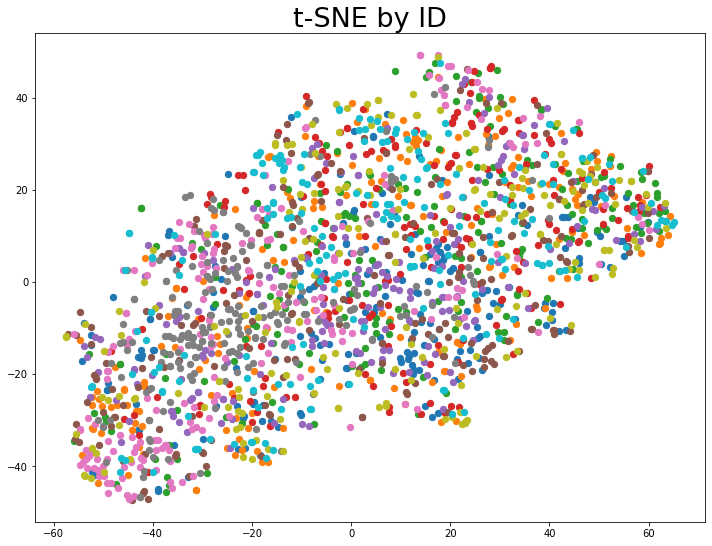

In [ ]:
plt.figure(figsize=(12,9))
#cols=['cyan','orange']
#i=0
for p in plot_tsne :
    plt.scatter(p[:,0], p[:,1], s=40)
    #plt.scatter(p[:,0], p[:,1], color = cols[colind[i]])
    #i+=1

plt.title('t-SNE by ID', size=27)
plt.savefig('tsne_by_ID(GRU_dim_reduction).pdf', dpi=330, format='pdf')

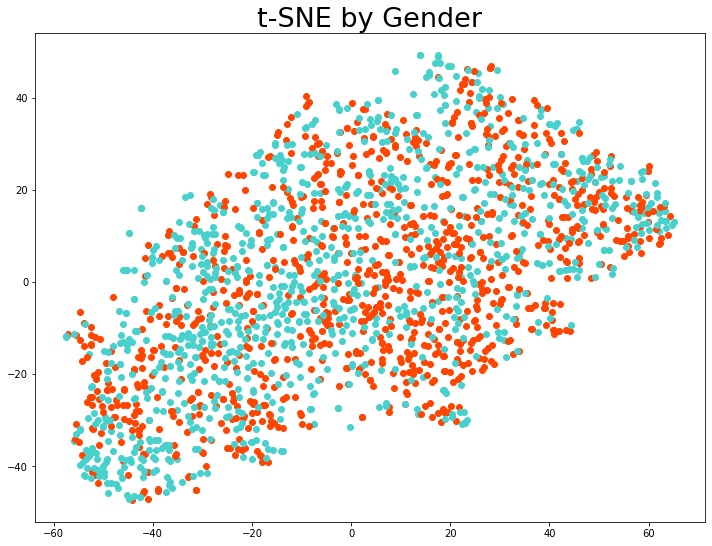

In [ ]:
#colind = [1,0,0,1,1,1,1,1,1,0]   # (2)
colind = [1,1,0,1,1,1,0,0,0,0]   # (4)

plt.figure(figsize=(12,9))
cols=['mediumturquoise','orangered']
i=0
for p in plot_tsne :
    plt.scatter(p[:,0], p[:,1], color = cols[colind[i]])
    i+=1

plt.title('t-SNE by Gender', size=27)
plt.savefig('tsne_by_Gend(GRU_dim_reduction).pdf', dpi=330, format='pdf')

In [ ]:
net.load_state_dict(torch.load('/content/drive/MyDrive/BlogAuthorClass/model_v3'))

<All keys matched successfully>

In [ ]:
torch.save(net.state_dict(), '/content/drive/MyDrive/BlogAuthorClass/model_v4')